# Feb ??, 2022 (Structural Connectome)

**Motivation**:  <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
sys.path.insert(0, pjoin(git_dir, 'mouse_connectivity_models'))

In [3]:
from mcmodels.core import VoxelModelCache
cache = VoxelModelCache(manifest_file='connectivity/voxel_model_manifest.json')
print(cache.to_json())

{
  "resolution": 100,
  "cache": true,
  "manifest_file": "connectivity/voxel_model_manifest.json",
  "ccf_version": "annotation/ccf_2017",
  "base_uri": null,
  "version": 1.3
}

In [4]:
voxel_array, source_mask, target_mask = cache.get_voxel_connectivity_array()
voxel_array

VoxelConnectivityArray(dtype=float64, shape=(226346, 448962))

In [5]:
# some given source/target voxels
source, target = 20353, 68902

# we index the VoxelConnectivyArray object just like it is a numpy ndarray
connection_strength = voxel_array[source, target]

# a row would be the bi-lateral connection strength from a given voxel
row = voxel_array[source]

# a column would be the connection strength to a given voxel
# from each voxel in the right hemisphere
column = voxel_array[:, target]

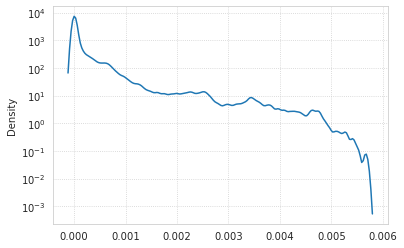

In [6]:
sns.kdeplot(row[row.nonzero()])
plt.yscale('log')

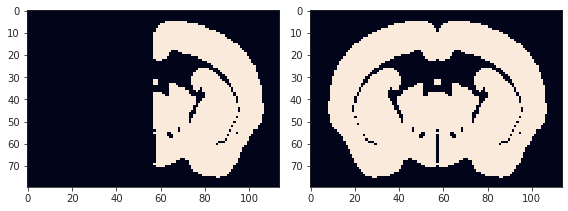

In [7]:
fig, axes = create_figure(1, 2, (8, 3.5))
axes[0].imshow(source_mask.mask[60])
axes[1].imshow(target_mask.mask[60])
plt.show()

In [8]:
source_mask.coordinates

array([[  1,  33,  61],
       [  1,  33,  62],
       [  1,  33,  63],
       ...,
       [131,  73,  66],
       [131,  73,  67],
       [131,  73,  71]])

In [9]:
target_mask.coordinates

array([[  1,  33,  49],
       [  1,  33,  50],
       [  1,  33,  51],
       ...,
       [131,  73,  66],
       [131,  73,  67],
       [131,  73,  71]])

## Parc

In [10]:
mice = Mice(128)
cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)

regions_r = mice.parcel.encode(hcl[hcl[:, 0] == 2])
cortex_r = dc(cortex)
cortex_r[~np.isin(cortex, regions_r)] = 0

len(regions), len(regions_r), cortex.shape

(768, 384, (132, 80, 114))

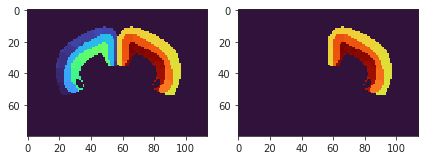

In [11]:
fig, axes = create_figure(1, 2)
axes[0].imshow(cortex[40], cmap='turbo');
axes[1].imshow(cortex_r[40], cmap='turbo');

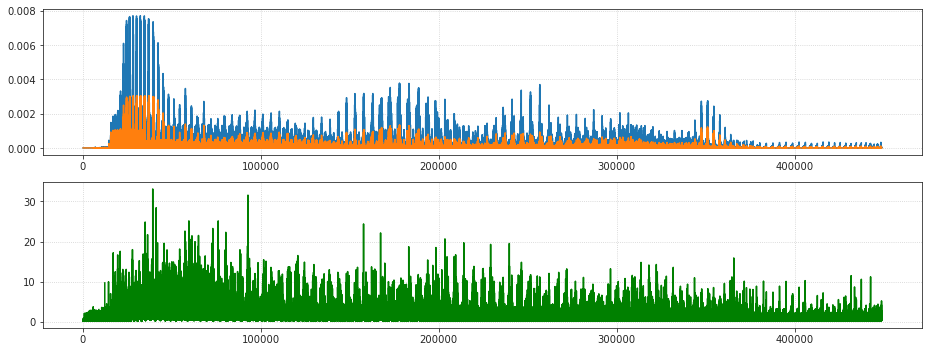

In [38]:
src_ids = np.where(source_mask.mask_volume(cortex == 385))[0]
row = voxel_array[src_ids]
mu = row.mean(0)
sd = row.std(0)

fig, axes = create_figure(2, 1, (13, 5))
axes[0].plot(mu)
axes[0].plot(sd)
axes[1].plot(mu / sd, color='g')
add_grid(axes)
plt.show()

In [37]:
rows = np.zeros((len(regions_r), *target_mask.masked_shape))
for i, idx in tqdm(enumerate(regions_r), total=len(regions_r)):
    src_ids = np.where(source_mask.mask_volume(cortex == idx))[0]
    rows[i] = voxel_array[src_ids].mean(0)

  0%|          | 0/384 [00:00<?, ?it/s]

In [39]:
np.min(rows[0]), np.max(rows[0])

(0.0, 0.007703898333781295)

In [224]:
i = 60
thres = 1e-13
out = np.zeros(target_mask.mask.shape)
for j, coo in enumerate(target_mask.coordinates):
    if rows[0, j] < thres:
        continue
    coo_flat = np.ravel_multi_index(coo, out.shape)
    out.flat[coo_flat] = rows[i, j]

In [225]:
template = mice.al.mcc.get_template_volume()[0]

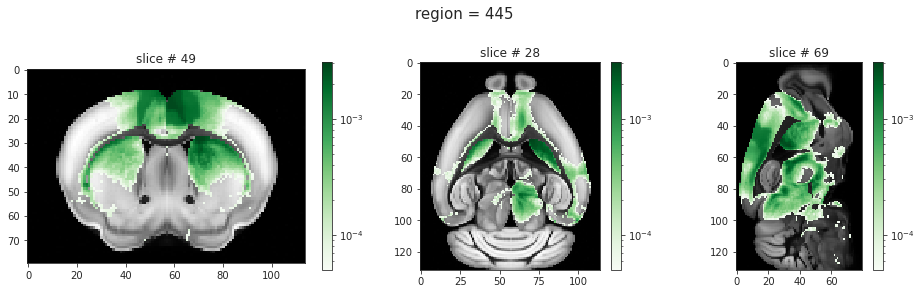

In [226]:
fig, axes = create_figure(1, 3, (13, 4), width_ratios=[1.6, 1.05, 1])
slices = np.unravel_index(np.argmax(out), out.shape)
for j, ax in enumerate(axes.flat):
    s = slices[j]
    ax.imshow(np.take(template, s, j), cmap='Greys_r')
    x2plt = np.take(out, s, j)
    x2plt = np.ma.masked_where(x2plt < 5e-5, x2plt)

    im = ax.imshow(x2plt, cmap='Greens', norm=matplotlib.colors.LogNorm())
    plt.colorbar(im, ax=ax)
    ax.set_title(f'slice # {s}')
fig.suptitle(f"region = {regions_r[i]}", fontsize=15, y=1.01)
plt.show()

## Hier

In [43]:
rows.shape

(384, 448962)

In [382]:
hcl = mice.parcel.decode(regions_r)
hcl

array([[  2,   1,   0],
       [  2,   2,   0],
       [  2,   3,   0],
       ...,
       [  2, 126,   2],
       [  2, 127,   2],
       [  2, 128,   2]])

In [386]:
i = 13
hcl[i], hcl[128 + i]

(array([ 2, 14,  0]), array([ 2, 14,  1]))

[<matplotlib.lines.Line2D object at 0x7f20277ec550>]

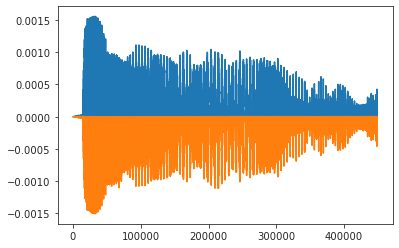

In [388]:
plt.plot(rows[i])
plt.plot(-rows[i + 128])

[<matplotlib.lines.Line2D object at 0x7f206dc1a670>]

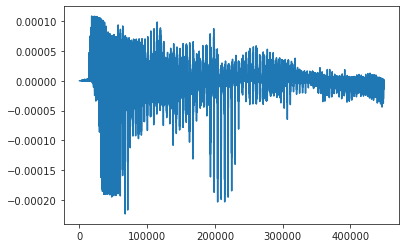

In [390]:
plt.plot(rows[i] - rows[i + 128])

In [56]:
rho, pval = sp_stats.spearmanr(rows.T)

In [80]:
d = 1 - rho
d = (d + d.T) / 2
np.fill_diagonal(d, 0.)
d.shape, rho.shape, pval.shape

((384, 384), (384, 384), (384, 384))

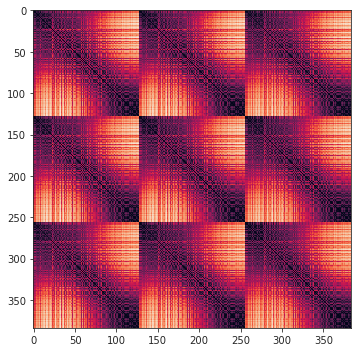

In [81]:
fig, ax = create_figure(figsize=(6, 5))
ax.imshow(d);

In [82]:
from analysis.hierarchical import get_clust_graph, sp_hier
z = sp_hier.linkage(
    sp_dist.squareform(d),
    method='ward',
    metric='correlation',
    optimal_ordering=True,
)

In [369]:
num_clusters = 7

result = get_clust_graph(
    linkage_mat=z,
    labels=regions_r,
    num_clusters=num_clusters,
)

In [370]:
base = Base(mice, num_clusters, mode='bold-ctx')

In [371]:
comm_vec = np.zeros(len(base.n2l))
for c_idx, clist in result['cluster_assigns'].items():
    hcl = mice.parcel.decode(clist)
    hcl[:, 0] = 1
    members = mice.parcel.encode(hcl).tolist() + clist
    hcl = mice.parcel.decode(members)
    for hh, cc, ll in hcl:
        lbl = f"{hh}-{cc}-{ll}"
        try:
            comm_vec[base.l2n[lbl]] = c_idx
        except KeyError:
            continue
comm_vec = comm_vec.astype(int)

In [372]:
np.unique(comm_vec)

array([1, 2, 3, 4, 5, 6, 7])

In [373]:
pi_disjoint = np.zeros((num_clusters, len(comm_vec)))
for i, c in enumerate(comm_vec):
    pi_disjoint[c - 1, i] = 1

In [374]:
mapping = base.align_centroid_to_structs(pi_disjoint)
pi_disjoint = pi_disjoint[mapping]

In [375]:
partition = np.argmax(pi_disjoint, 0) + 1
proj = base.project_vec(partition, layer=0, add_disjoint=False)

<matplotlib.image.AxesImage object at 0x7f2026b81d00>

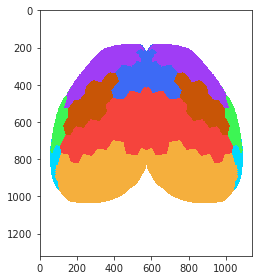

In [376]:
x2plt = proj['top'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)

fig, ax = create_figure()
plt.imshow(x2plt, cmap=base.cmaps[-1])

<matplotlib.image.AxesImage object at 0x7f2027b2a8b0>

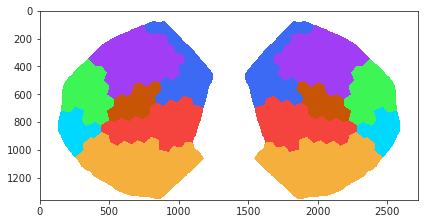

In [377]:
x2plt = proj['flat'][0]
x2plt = np.ma.masked_where(x2plt == 0, x2plt)

fig, ax = create_figure()
plt.imshow(x2plt, cmap=base.cmaps[-1])